In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('../data/base_target2_data.csv')
df = df.set_index('date_id')  # DO NOT parse as datetime



# Confirm structure
print(df.shape)
df.head()


(1830, 3)


,LME_CA_Close,LME_ZS_Close,target_2_shifted
date_id,,,
0,7205.0,3349.0,-0.007052
1,7147.0,3327.0,-0.008934
2,7188.5,3362.0,0.011943
3,7121.0,3354.0,0.006856
4,7125.0,3386.0,-0.016626


In [2]:
# Chronological split ratios
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
test_size = len(df) - train_size - val_size

# Index-based split
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]

print(f"Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")


Train: (1281, 3), Val: (274, 3), Test: (275, 3)


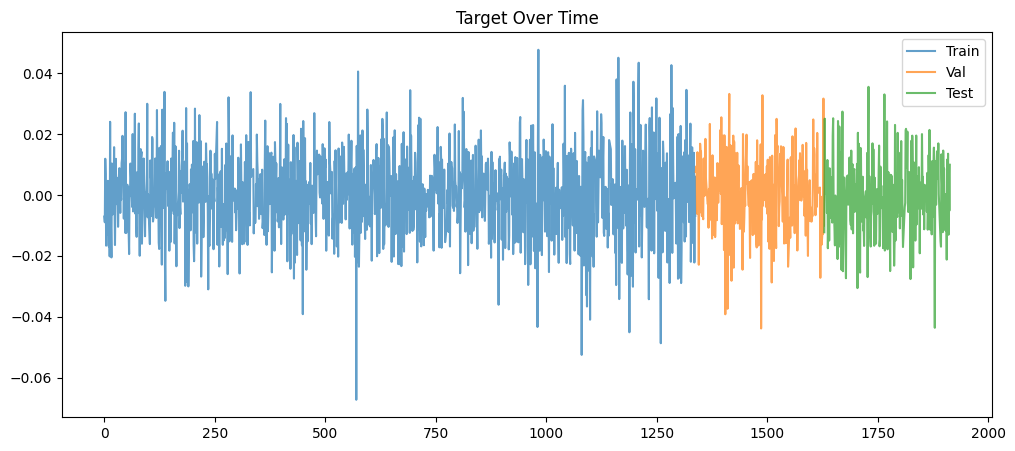

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train['target_2_shifted'], label='Train', alpha=0.7)
plt.plot(val['target_2_shifted'], label='Val', alpha=0.7)
plt.plot(test['target_2_shifted'], label='Test', alpha=0.7)
plt.title("Target Over Time")
plt.legend()
plt.show()


Create Lag Features for Baseline

In [4]:
# Create lag features for price and target history
lag_features = ['LME_CA_Close', 'LME_ZS_Close', 'target_2_shifted']
lags = [1, 2, 3]

for col in lag_features:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Drop initial rows that have NaNs due to lagging
df = df.dropna().copy()


Define features and target

In [5]:
from sklearn.model_selection import train_test_split

# Drop the original columns (optional, but recommended for clarity)
drop_cols = ['LME_CA_Close', 'LME_ZS_Close', 'target_2_shifted']
feature_cols = [col for col in df.columns if col not in drop_cols]

X = df[feature_cols]
y = df['target_2_shifted']


Time-aware train/val/test split

In [6]:
X_train, y_train = X.iloc[:1281], y.iloc[:1281]
X_val, y_val = X.iloc[1281:1555], y.iloc[1281:1555]
X_test, y_test = X.iloc[1555:], y.iloc[1555:]


Fit a simple regressor

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model = Ridge(alpha=1.0)  # Regularized linear regression
model.fit(X_train, y_train)

# Predictions
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)


Evaluation

In [8]:
def print_metrics(y_true, y_pred, label='Set'):
    print(f"--- {label} ---")
    print("R²:  ", round(r2_score(y_true, y_pred), 4))
    print("MAE: ", round(mean_absolute_error(y_true, y_pred), 5))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 5))

print_metrics(y_train, pred_train, "Train")
print_metrics(y_val, pred_val, "Validation")
print_metrics(y_test, pred_test, "Test")


--- Train ---
R²:   0.0148
MAE:  0.01044
RMSE: 0.01338
--- Validation ---
R²:   -0.0032
MAE:  0.00969
RMSE: 0.01234
--- Test ---
R²:   -0.0255
MAE:  0.00912
RMSE: 0.01161


Add Rolling Features (momentum/trend/volatility)

In [9]:
for window in [3, 7, 14]:
    df[f'CA_roll_mean_{window}'] = df['LME_CA_Close'].rolling(window).mean()
    df[f'ZS_roll_mean_{window}'] = df['LME_ZS_Close'].rolling(window).mean()
    df[f'target_roll_std_{window}'] = df['target_2_shifted'].rolling(window).std()
df.dropna(inplace=True)

print(df.columns.tolist())


['LME_CA_Close', 'LME_ZS_Close', 'target_2_shifted', 'LME_CA_Close_lag1', 'LME_CA_Close_lag2', 'LME_CA_Close_lag3', 'LME_ZS_Close_lag1', 'LME_ZS_Close_lag2', 'LME_ZS_Close_lag3', 'target_2_shifted_lag1', 'target_2_shifted_lag2', 'target_2_shifted_lag3', 'CA_roll_mean_3', 'ZS_roll_mean_3', 'target_roll_std_3', 'CA_roll_mean_7', 'ZS_roll_mean_7', 'target_roll_std_7', 'CA_roll_mean_14', 'ZS_roll_mean_14', 'target_roll_std_14']


Redo the train/val/test split

In [10]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

train = df.iloc[:train_size]
val = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]


Define features and target

In [11]:
X_train = train.drop(columns=['target_2_shifted'])
y_train = train['target_2_shifted']

X_val = val.drop(columns=['target_2_shifted'])
y_val = val['target_2_shifted']

X_test = test.drop(columns=['target_2_shifted'])
y_test = test['target_2_shifted']


Train Ridge again

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

model = Ridge()
model.fit(X_train, y_train)

def evaluate(model, X, y, name="Set"):
    pred = model.predict(X)
    r2 = r2_score(y, pred)
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    print(f"--- {name} ---")
    print(f"R²:   {r2:.4f}")
    print(f"MAE:  {mae:.5f}")
    print(f"RMSE: {rmse:.5f}")

evaluate(model, X_train, y_train, "Train")
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")


--- Train ---
R²:   0.0211
MAE:  0.01046
RMSE: 0.01339
--- Validation ---
R²:   -0.0311
MAE:  0.00996
RMSE: 0.01264
--- Test ---
R²:   -0.0188
MAE:  0.00965
RMSE: 0.01218


In [13]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# import numpy as np

# Re-split (safe in case kernel restarted)
split_idx1 = int(len(df) * 0.7)
split_idx2 = int(len(df) * 0.85)
train_df = df.iloc[:split_idx1].copy()
val_df = df.iloc[split_idx1:split_idx2].copy()
test_df = df.iloc[split_idx2:].copy()

# Define features and target
target = 'target_2_shifted'
features = [col for col in df.columns if col != target]

X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

# Train model
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train, y_train)

# Evaluate
def evaluate(model, X, y, name=''):
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))  # <- fix for older sklearn
    print(f"--- {name} ---")
    print(f"R²:   {r2:.4f}")
    print(f"MAE:  {mae:.5f}")
    print(f"RMSE: {rmse:.5f}")


evaluate(lgb_model, X_train, y_train, "Train")
evaluate(lgb_model, X_val, y_val, "Validation")
evaluate(lgb_model, X_test, y_test, "Test")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
--- Train ---
R²:   0.7627
MAE:  0.00473
RMSE: 0.00659
--- Validation ---
R²:   0.2861
MAE:  0.00787
RMSE: 0.01052
--- Test ---
R²:   0.1906
MAE:  0.00821
RMSE: 0.01085


Now What?

Inspect Feature Importances

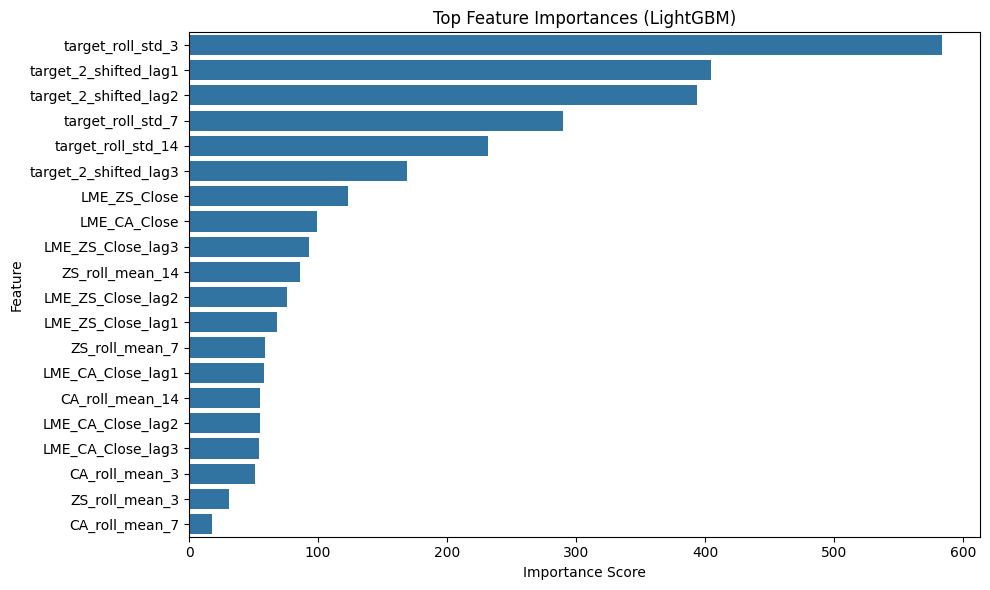

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_importances(model, feature_names, top_n=20):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1][:top_n]
    top_features = [feature_names[i] for i in sorted_idx]
    top_importances = importances[sorted_idx]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_importances, y=top_features, orient="h")
    plt.title("Top Feature Importances (LightGBM)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_importances(lgb_model, X_train.columns.tolist())


In [15]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = mse ** 0.5
    return rmse



c:\Users\andre\source\kaggle_competitions\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Try 50 first, can go to 100+


[I 2025-07-28 15:10:01,580] A new study created in memory with name: no-name-0a31a052-93e2-4791-a7b6-30e0e66fd2ca


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:01,881] Trial 0 finished with value: 0.012102529498726271 and parameters: {'num_leaves': 93, 'max_depth': 11, 'learning_rate': 0.27392710448883195, 'n_estimators': 561, 'min_child_samples': 32, 'subsample': 0.8332900729136485, 'colsample_bytree': 0.6511856328236985}. Best is trial 0 with value: 0.012102529498726271.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:02,080] Trial 1 finished with value: 0.011084894833899413 and parameters: {'num_leaves': 27, 'max_depth': 7, 'learning_rate': 0.20101049350080583, 'n_estimators': 497, 'min_child_samples': 15, 'subsample': 0.9181899531336064, 'colsample_bytree': 0.6885361176487064}. Best is trial 1 with value: 0.011084894833899413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:02,244] Trial 2 finished with value: 0.010985163448068323 and parameters: {'num_leaves': 36, 'max_depth': 8, 'learning_rate': 0.009748572225614857, 'n_estimators': 248, 'min_child_samples': 5, 'subsample': 0.5640664019898772, 'colsample_bytree': 0.6879976894317876}. Best is trial 2 with value: 0.010985163448068323.
[I 2025-07-28 15:10:02,297] Trial 3 finished with value: 0.011609904551585918 and parameters: {'num_leaves': 19, 'max_depth': 4, 'learning_rate': 0.29377652606685456, 'n_estimators': 253, 'min_child_samples': 41, 'subsample': 0.6419463321158438, 'colsample_bytree': 0.752323538636118}. Best is trial 2 with value: 0.010985163448068323.
[I 2025-07-28 15:10:02,357] Trial 4 finished with value: 0.011173415691945464 and parameters: {'num_leaves': 78, 'max_depth': 3, 'learning_rate': 0.03643504347078449, 'n_estimators': 330, 'min_child_samples': 19, 'subsample': 0.5920389053809159, 'colsample_bytree': 0.7192106756178092}. Best is trial 2 with value: 0.0109851634

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:02,677] Trial 5 finished with value: 0.01073803693587999 and parameters: {'num_leaves': 81, 'max_depth': 6, 'learning_rate': 0.016877517425176163, 'n_estimators': 768, 'min_child_samples': 15, 'subsample': 0.8071375015228779, 'colsample_bytree': 0.5432397337662802}. Best is trial 5 with value: 0.01073803693587999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:02,880] Trial 6 finished with value: 0.010733213924954785 and parameters: {'num_leaves': 21, 'max_depth': 6, 'learning_rate': 0.02447903815645934, 'n_estimators': 708, 'min_child_samples': 34, 'subsample': 0.901319809715038, 'colsample_bytree': 0.8841896804266163}. Best is trial 6 with value: 0.010733213924954785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:03,223] Trial 7 finished with value: 0.010721267767994848 and parameters: {'num_leaves': 72, 'max_depth': 7, 'learning_rate': 0.060040058304667444, 'n_estimators': 639, 'min_child_samples': 12, 'subsample': 0.6346095437955617, 'colsample_bytree': 0.7726342163907387}. Best is trial 7 with value: 0.010721267767994848.
[I 2025-07-28 15:10:03,288] Trial 8 finished with value: 0.012009936375523701 and parameters: {'num_leaves': 89, 'max_depth': 12, 'learning_rate': 0.002930456717958361, 'n_estimators': 140, 'min_child_samples': 47, 'subsample': 0.7898231280636892, 'colsample_bytree': 0.7021126574833058}. Best is trial 7 with value: 0.010721267767994848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:03,865] Trial 9 finished with value: 0.010980365923111654 and parameters: {'num_leaves': 78, 'max_depth': 6, 'learning_rate': 0.00214706518820179, 'n_estimators': 985, 'min_child_samples': 8, 'subsample': 0.6788051918518397, 'colsample_bytree': 0.7237904959240193}. Best is trial 7 with value: 0.010721267767994848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:04,371] Trial 10 finished with value: 0.01094352879294852 and parameters: {'num_leaves': 54, 'max_depth': 9, 'learning_rate': 0.05712335609547319, 'n_estimators': 985, 'min_child_samples': 23, 'subsample': 0.7104441835759892, 'colsample_bytree': 0.9639580904397598}. Best is trial 7 with value: 0.010721267767994848.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2025-07-28 15:10:04,592] Trial 11 finished with value: 0.010966162630645222 and parameters: {'num_leaves': 57, 'max_depth': 5, 'learning_rate': 0.06872981061027784, 'n_estimators': 702, 'min_child_samples': 32, 'subsample': 0.9996926757383063, 'colsample_bytree': 0.869713405988793}. Best is trial 7 with value: 0.010721267767994848.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:04,967] Trial 12 finished with value: 0.010432180278372186 and parameters: {'num_leaves': 56, 'max_depth': 9, 'learning_rate': 0.00738394173355294, 'n_estimators': 753, 'min_child_samples': 38, 'subsample': 0.5023916139885559, 'colsample_bytree': 0.8456074501399184}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:05,339] Trial 13 finished with value: 0.010524254444102158 and parameters: {'num_leaves': 57, 'max_depth': 10, 'learning_rate': 0.008430544906624891, 'n_estimators': 820, 'min_child_samples': 42, 'subsample': 0.5038233232966634, 'colsample_bytree': 0.8165050465539416}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:05,729] Trial 14 finished with value: 0.0105484193763393 and parameters: {'num_leaves': 52, 'max_depth': 10, 'learning_rate': 0.00893190329462182, 'n_estimators': 830, 'min_child_samples': 43, 'subsample': 0.5052129676948836, 'colsample_bytree': 0.82909365651763}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:06,155] Trial 15 finished with value: 0.010525523535641946 and parameters: {'num_leaves': 43, 'max_depth': 9, 'learning_rate': 0.004741803819129377, 'n_estimators': 857, 'min_child_samples': 49, 'subsample': 0.5160398385275047, 'colsample_bytree': 0.998059471724847}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:06,413] Trial 16 finished with value: 0.01176891137971317 and parameters: {'num_leaves': 64, 'max_depth': 10, 'learning_rate': 0.001079276015034082, 'n_estimators': 470, 'min_child_samples': 38, 'subsample': 0.5656633123960683, 'colsample_bytree': 0.818527954553192}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:06,945] Trial 17 finished with value: 0.010581505983630207 and parameters: {'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.007846594123456797, 'n_estimators': 881, 'min_child_samples': 25, 'subsample': 0.7310820164789467, 'colsample_bytree': 0.9082426703637274}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:07,115] Trial 18 finished with value: 0.011264065448957371 and parameters: {'num_leaves': 10, 'max_depth': 9, 'learning_rate': 0.003991176859465572, 'n_estimators': 616, 'min_child_samples': 37, 'subsample': 0.5160064118417452, 'colsample_bytree': 0.6235854716355356}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:07,498] Trial 19 finished with value: 0.010616407798524062 and parameters: {'num_leaves': 64, 'max_depth': 11, 'learning_rate': 0.015484084798454718, 'n_estimators': 777, 'min_child_samples': 44, 'subsample': 0.6129445073632098, 'colsample_bytree': 0.7919517258088032}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:08,098] Trial 20 finished with value: 0.01092475257340472 and parameters: {'num_leaves': 99, 'max_depth': 8, 'learning_rate': 0.0014277289876823954, 'n_estimators': 915, 'min_child_samples': 28, 'subsample': 0.5570514059821674, 'colsample_bytree': 0.9361528806602285}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:08,476] Trial 21 finished with value: 0.01052660882690532 and parameters: {'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.0047754431926641475, 'n_estimators': 876, 'min_child_samples': 49, 'subsample': 0.5382104804524422, 'colsample_bytree': 0.9983160324963364}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:08,818] Trial 22 finished with value: 0.010456707307770636 and parameters: {'num_leaves': 36, 'max_depth': 10, 'learning_rate': 0.0054149958957898335, 'n_estimators': 785, 'min_child_samples': 50, 'subsample': 0.5164643913584048, 'colsample_bytree': 0.9995360338802299}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:09,171] Trial 23 finished with value: 0.010537270536273279 and parameters: {'num_leaves': 33, 'max_depth': 10, 'learning_rate': 0.006324724452544922, 'n_estimators': 744, 'min_child_samples': 45, 'subsample': 0.5008970456108947, 'colsample_bytree': 0.8421941323375853}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:09,532] Trial 24 finished with value: 0.01053411285678874 and parameters: {'num_leaves': 64, 'max_depth': 11, 'learning_rate': 0.011538251898195039, 'n_estimators': 685, 'min_child_samples': 40, 'subsample': 0.671749849302937, 'colsample_bytree': 0.9267164732717583}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:09,874] Trial 25 finished with value: 0.010714071460205822 and parameters: {'num_leaves': 49, 'max_depth': 10, 'learning_rate': 0.002669876497056338, 'n_estimators': 799, 'min_child_samples': 50, 'subsample': 0.5798596377180146, 'colsample_bytree': 0.8667038711648012}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train s

[I 2025-07-28 15:10:10,119] Trial 26 finished with value: 0.010668190192396712 and parameters: {'num_leaves': 58, 'max_depth': 8, 'learning_rate': 0.023411437771857342, 'n_estimators': 597, 'min_child_samples': 38, 'subsample': 0.6094311403851143, 'colsample_bytree': 0.7969677786571653}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:10,597] Trial 27 finished with value: 0.010554765258936187 and parameters: {'num_leaves': 35, 'max_depth': 11, 'learning_rate': 0.0061027782977812585, 'n_estimators': 933, 'min_child_samples': 46, 'subsample': 0.5435934275332486, 'colsample_bytree': 0.9657364111676516}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:10,882] Trial 28 finished with value: 0.011762759369300138 and parameters: {'num_leaves': 69, 'max_depth': 12, 'learning_rate': 0.002004235958314959, 'n_estimators': 515, 'min_child_samples': 35, 'subsample': 0.6634914889620234, 'colsample_bytree': 0.5678920220776924}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:11,196] Trial 29 finished with value: 0.010637347443593419 and parameters: {'num_leaves': 48, 'max_depth': 11, 'learning_rate': 0.013442343725970142, 'n_estimators': 558, 'min_child_samples': 29, 'subsample': 0.5363766394699134, 'colsample_bytree': 0.6066755224571425}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:11,408] Trial 30 finished with value: 0.010824891799242908 and parameters: {'num_leaves': 30, 'max_depth': 10, 'learning_rate': 0.0036002821672837565, 'n_estimators': 409, 'min_child_samples': 42, 'subsample': 0.5947990497823723, 'colsample_bytree': 0.902541748305145}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:11,788] Trial 31 finished with value: 0.010459484795698932 and parameters: {'num_leaves': 42, 'max_depth': 9, 'learning_rate': 0.005371019794397307, 'n_estimators': 837, 'min_child_samples': 50, 'subsample': 0.516805979688264, 'colsample_bytree': 0.9982735299693511}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:12,153] Trial 32 finished with value: 0.01052012861401179 and parameters: {'num_leaves': 38, 'max_depth': 9, 'learning_rate': 0.0062835798091010015, 'n_estimators': 814, 'min_child_samples': 46, 'subsample': 0.5453098514477792, 'colsample_bytree': 0.9545973498476145}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:12,537] Trial 33 finished with value: 0.010574128061651925 and parameters: {'num_leaves': 41, 'max_depth': 8, 'learning_rate': 0.006352828017179981, 'n_estimators': 940, 'min_child_samples': 47, 'subsample': 0.5445580951943877, 'colsample_bytree': 0.9597971339290154}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:12,813] Trial 34 finished with value: 0.012060630444523865 and parameters: {'num_leaves': 24, 'max_depth': 9, 'learning_rate': 0.14814492813311103, 'n_estimators': 666, 'min_child_samples': 50, 'subsample': 0.6281194399658789, 'colsample_bytree': 0.9532240283236453}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:13,146] Trial 35 finished with value: 0.010635540285566254 and parameters: {'num_leaves': 40, 'max_depth': 7, 'learning_rate': 0.02495264095202154, 'n_estimators': 747, 'min_child_samples': 46, 'subsample': 0.5737987775843609, 'colsample_bytree': 0.9819873492546857}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:13,500] Trial 36 finished with value: 0.0105818533687019 and parameters: {'num_leaves': 27, 'max_depth': 8, 'learning_rate': 0.00323893924379419, 'n_estimators': 808, 'min_child_samples': 48, 'subsample': 0.5280045232483341, 'colsample_bytree': 0.914706445783527}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:13,810] Trial 37 finished with value: 0.01049906493886131 and parameters: {'num_leaves': 17, 'max_depth': 9, 'learning_rate': 0.004928863356237183, 'n_estimators': 733, 'min_child_samples': 40, 'subsample': 0.8627640528515054, 'colsample_bytree': 0.9322265400341478}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:14,072] Trial 38 finished with value: 0.011126785135814884 and parameters: {'num_leaves': 13, 'max_depth': 7, 'learning_rate': 0.002131382726556602, 'n_estimators': 726, 'min_child_samples': 31, 'subsample': 0.863548526722424, 'colsample_bytree': 0.8878405173114452}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:14,388] Trial 39 finished with value: 0.010521097424816024 and parameters: {'num_leaves': 17, 'max_depth': 8, 'learning_rate': 0.01114535197866311, 'n_estimators': 631, 'min_child_samples': 40, 'subsample': 0.9866822799944539, 'colsample_bytree': 0.933643206662946}. Best is trial 12 with value: 0.010432180278372186.
[I 2025-07-28 15:10:14,539] Trial 40 finished with value: 0.011289463671221 and parameters: {'num_leaves': 22, 'max_depth': 3, 'learning_rate': 0.004480042522549306, 'n_estimators': 584, 'min_child_samples': 35, 'subsample': 0.9544156006375539, 'colsample_bytree': 0.8537957190435058}. Best is trial 12 with value: 0.010432180278372186.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:14,911] Trial 41 finished with value: 0.010416822837171913 and parameters: {'num_leaves': 35, 'max_depth': 9, 'learning_rate': 0.005978109600308171, 'n_estimators': 779, 'min_child_samples': 45, 'subsample': 0.7915230014921385, 'colsample_bytree': 0.9827861597999206}. Best is trial 41 with value: 0.010416822837171913.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:15,318] Trial 42 finished with value: 0.010448727051094382 and parameters: {'num_leaves': 29, 'max_depth': 9, 'learning_rate': 0.005124004853604448, 'n_estimators': 856, 'min_child_samples': 44, 'subsample': 0.7834703435917619, 'colsample_bytree': 0.9934128988909452}. Best is trial 41 with value: 0.010416822837171913.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:15,781] Trial 43 finished with value: 0.010428821761010901 and parameters: {'num_leaves': 30, 'max_depth': 9, 'learning_rate': 0.007743714133752953, 'n_estimators': 896, 'min_child_samples': 44, 'subsample': 0.7797531681505041, 'colsample_bytree': 0.9849895943803267}. Best is trial 41 with value: 0.010416822837171913.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:16,181] Trial 44 finished with value: 0.010713700779047692 and parameters: {'num_leaves': 30, 'max_depth': 10, 'learning_rate': 0.020627526156556043, 'n_estimators': 897, 'min_child_samples': 44, 'subsample': 0.7814181848305397, 'colsample_bytree': 0.9805579258220296}. Best is trial 41 with value: 0.010416822837171913.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:16,578] Trial 45 finished with value: 0.010444406433527904 and parameters: {'num_leaves': 26, 'max_depth': 8, 'learning_rate': 0.00833759538302471, 'n_estimators': 967, 'min_child_samples': 43, 'subsample': 0.7565442900648911, 'colsample_bytree': 0.976918570170151}. Best is trial 41 with value: 0.010416822837171913.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-28 15:10:16,940] Trial 46 finished with value: 0.010497687831314656 and parameters: {'num_leaves': 24, 'max_depth': 6, 'learning_rate': 0.00921138615292711, 'n_estimators': 987, 'min_child_samples': 37, 'subsample': 0.7549644666388695, 'colsample_bytree': 0.8894730308209882}. Best is trial 41 with value: 0.010416822837171913.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:17,316] Trial 47 finished with value: 0.010468444517877606 and parameters: {'num_leaves': 32, 'max_depth': 7, 'learning_rate': 0.007859344502275394, 'n_estimators': 951, 'min_child_samples': 43, 'subsample': 0.804535665455055, 'colsample_bytree': 0.9732980231427539}. Best is trial 41 with value: 0.010416822837171913.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:17,754] Trial 48 finished with value: 0.011056239393105629 and parameters: {'num_leaves': 27, 'max_depth': 8, 'learning_rate': 0.031005392860504265, 'n_estimators': 999, 'min_child_samples': 21, 'subsample': 0.8285638212861662, 'colsample_bytree': 0.7426633939669571}. Best is trial 41 with value: 0.010416822837171913.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-07-28 15:10:18,182] Trial 49 finished with value: 0.011021110587315757 and parameters: {'num_leaves': 20, 'max_depth': 7, 'learning_rate': 0.0024970901017418224, 'n_estimators': 859, 'min_child_samples': 42, 'subsample': 0.7121681578221555, 'colsample_bytree': 0.6722269744805026}. Best is trial 41 with value: 0.010416822837171913.


In [17]:
print("Best trial:")
print(study.best_trial.params)


Best trial:
{'num_leaves': 35, 'max_depth': 9, 'learning_rate': 0.005978109600308171, 'n_estimators': 779, 'min_child_samples': 45, 'subsample': 0.7915230014921385, 'colsample_bytree': 0.9827861597999206}


In [19]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

best_params = {
    'num_leaves': 35,
    'max_depth': 9,
    'learning_rate': 0.005978109600308171,
    'n_estimators': 779,
    'min_child_samples': 45,
    'subsample': 0.7915230014921385,
    'colsample_bytree': 0.9827861597999206,
    'random_state': 42
}

model = LGBMRegressor(**best_params)
model.fit(X_train, y_train)

# Predict
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

# Metrics
def print_metrics(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    print(f"--- {label} ---")
    print(f"R²:   {r2:.4f}")
    print(f"MAE:  {mae:.5f}")
    print(f"RMSE: {rmse:.5f}\n")

print_metrics(y_train, pred_train, "Train")
print_metrics(y_val, pred_val, "Validation")
print_metrics(y_test, pred_test, "Test")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 20
[LightGBM] [Info] Start training from score 0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [21]:
test_ids = test.index  # or test['id'] if applicable
submission = pd.DataFrame({'id': test_ids, 'target': pred_test})
submission.to_csv('../submissions/submission_lgbm_tuned.csv', index=False)
